## Sources ##

https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48



## Load packages ##

In [23]:
import torch
import torchvision
import torch.utils.data as data

import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from torch.utils.data import random_split

## Set parameters & load data ##

In [2]:
#train and test data folders
training_data_folder = 'worm_categories/train/'
test_data_folder     = 'worm_categories/test/' # make these the same data for now

In [3]:
classes = tuple(listdir(training_data_folder))
classes = [c for c in classes if c != ".DS_Store"]
classes

['No_Worms', 'Definitely_High', 'Unclear_Medium_or_High', 'Low_Worms']

In [34]:
resize_size = (500,500)

#load the train and test data
dataset = ImageFolder(
    training_data_folder,
    transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor()
    ]))

test_dataset = ImageFolder(
    test_data_folder,
    transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor()
    ]))

## Get device for training ##

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## A few tests ##

In [6]:
img, label = dataset[0]
print(img.shape,label)

#output :
#torch.Size([3, 150, 150]) 0

torch.Size([3, 150, 150]) 0


In [7]:
print("Follwing classes are there : \n",dataset.classes)

#output:
#Follwing classes are there : 
# ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Follwing classes are there : 
 ['Definitely_High', 'Low_Worms', 'No_Worms', 'Unclear_Medium_or_High']


## Display some sample images ##

In [8]:
# label_d = torchvision.datasets.ImageFolder(TRAIN_DATA_PATH).find_classes(TRAIN_DATA_PATH)[1]
# test_image = images[0]
# test_label = [k for k,v in label_d.items() if v==labels[0]]
# print([k for k,v in label_d.items() if v==labels[0]])
# plt.imshow( test_image.permute(1,2,0) );

In [9]:
# # functions to show an image

# def imshow(img):
#     # img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

In [10]:
# imshow(images[0])

In [11]:
# # get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

Label : Definitely_High


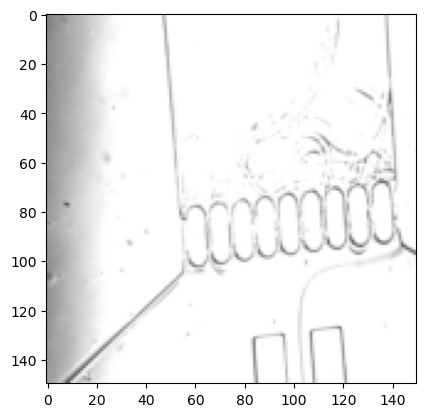

In [12]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [13]:
# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

## train, test split ##

In [14]:
batch_size    = 4
test_fraction = 0.2

val_size   = int(test_fraction*len(dataset))
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size,   num_workers = 4, pin_memory = True, shuffle = True)
val_dl   = DataLoader(val_data,   batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 64
Length of Validation Data : 16


## show_batch function ##

Visualize a batch

Label : ['No_Worms', 'No_Worms', 'Definitely_High', 'Low_Worms']


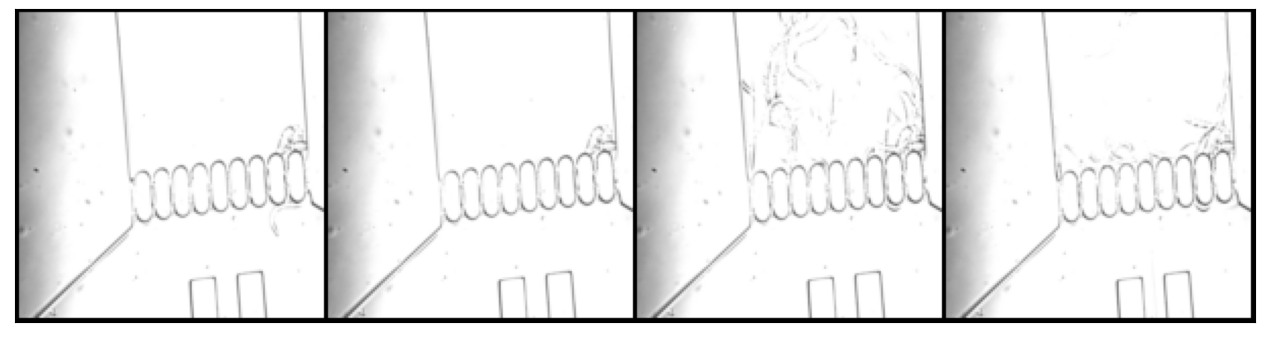

In [38]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
    print(f"Labels : {list([dataset.classes[label] for label in labels])}")
        
show_batch(train_dl)

In [ ]:
# data       = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
# train_size = int(0.75*(len(data)))
# val_size   = int(len(data) - train_size)

# train_size, val_size

In [ ]:
type(train_size), type(val_size)

In [ ]:
# train_data,val_data = random_split(data, [train_size, val_size])

## Set up neural network ##

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

##  Define a loss function and optimize  ##

In [ ]:
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Base class for image classification ##

First, we prepare a base class that extends the functionality of torch.nn.Module (base class used to develop all neural networks). We add various functionalities to the base to train the model, validate the model, and get the result for each epoch. This is reusable and can be used for any image classification model, no need to rewrite this every time.

In [24]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## CNN model ##

In [26]:
class Worm_Detector_Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

## Hyperparameters, model training and evaluation ##

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

## Train the network ##

In [30]:
num_epochs = 30
opt_func   = torch.optim.Adam
lr         = 0.001 # learning rate
model      = Worm_Detector_Classification()

In [31]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6673, val_loss: 1.4509, val_acc: 0.3125
Epoch [1], train_loss: 1.4699, val_loss: 1.4965, val_acc: 0.1875
Epoch [2], train_loss: 1.4905, val_loss: 1.4031, val_acc: 0.2500
Epoch [3], train_loss: 1.4720, val_loss: 1.4415, val_acc: 0.2500
Epoch [4], train_loss: 1.4215, val_loss: 1.3980, val_acc: 0.3125
Epoch [5], train_loss: 1.4200, val_loss: 1.4133, val_acc: 0.1875
Epoch [6], train_loss: 1.4043, val_loss: 1.3939, val_acc: 0.2500
Epoch [7], train_loss: 1.4092, val_loss: 1.3862, val_acc: 0.3125
Epoch [8], train_loss: 1.4056, val_loss: 1.3980, val_acc: 0.1875
Epoch [9], train_loss: 1.4029, val_loss: 1.3986, val_acc: 0.1875
Epoch [10], train_loss: 1.4036, val_loss: 1.3906, val_acc: 0.1875
Epoch [11], train_loss: 1.4044, val_loss: 1.4012, val_acc: 0.1875
Epoch [12], train_loss: 1.4040, val_loss: 1.4021, val_acc: 0.2500
Epoch [13], train_loss: 1.3987, val_loss: 1.4043, val_acc: 0.1875
Epoch [14], train_loss: 1.3999, val_loss: 1.4002, val_acc: 0.1875
Epoch [15], train_lo

In [ ]:
# for i, data in enumerate(train_data_loader, 0):
#     inputs, labels = data

In [ ]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_data_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')